In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
x = dataset.data[:,dataset.labels.==0]
y = dataset.labels

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [3]:
# VAE settings
indim = size(x,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.001 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(y[y.==1],1)/size(y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
L = 100 # samples for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, activation = activation, rdelta = rdelta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 0.001, 0, 0.1262135922330097, 2000, 500, true, 100, 0.001)

In [4]:
# fit the model
AnomalyDetection.evalloss(model, x)
AnomalyDetection.fit!(model, x)
AnomalyDetection.evalloss(model, x)

loss: 0.73088
reconstruction error: 0.740815
KL: 0.277043

loss: 0.0140539
reconstruction error: 0.0111546
KL: 2.94296

loss: 0.0133453
reconstruction error: 0.0103359
KL: 2.85361

loss: 0.0129121
reconstruction error: 0.0102925
KL: 2.57982

loss: 0.0126814
reconstruction error: 0.00944181
KL: 2.44697

loss: 0.011582
reconstruction error: 0.00979744
KL: 2.44697



In [5]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.704033  0.695124  0.696442  0.668192  …  0.01276  0.0505091  0.0722892
 0.711753  0.702993  0.727523  0.711313     1.00259  0.982506   0.972753 

In [6]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [7]:
AnomalyDetection.mu(model, x)

Tracked 2×90 Array{Float64,2}:
 -0.239109  -0.245931  -0.240529  …  -1.57429   -1.59368   -1.52348 
  0.374441   0.379027   0.375525      0.487141   0.496098   0.484339

In [8]:
AnomalyDetection.sigma(model,x)

Tracked 2×90 Array{Float64,2}:
 0.137983  0.1351    0.1373    0.133058  …  0.0682319  0.0653185  0.0696424
 0.502068  0.501078  0.501832  0.500354     0.590976   0.589578   0.586814 

In [9]:
AnomalyDetection.sample_z(model, x)

Tracked 2×90 Array{Float64,2}:
 -0.0440437  -0.284204  -0.14094   …  -1.6736   -1.64481   -1.53388
  0.848996    0.696904   0.294064     -0.22928   0.570778   1.3941 

In [10]:
# predict labels
X = dataset.data
y = dataset.labels
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0

In [11]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 84
  fp = 6
  fn = 1
precision: 0.6666666666666666
recall: 0.9230769230769231
f1score: 0.7741935483870968
equal error rate: 0.07179487179487179

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 84
  fp = 6
  fn = 1
precision: 0.6666666666666666
recall: 0.9230769230769231
f1score: 0.7741935483870968
equal error rate: 0.07179487179487179


In [12]:
using ScikitLearn.Utils: meshgrid

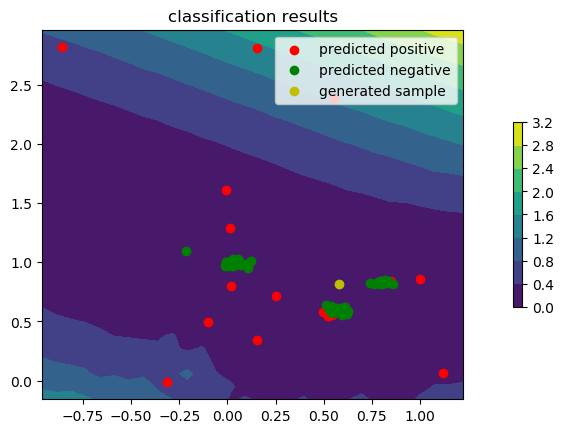

In [13]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

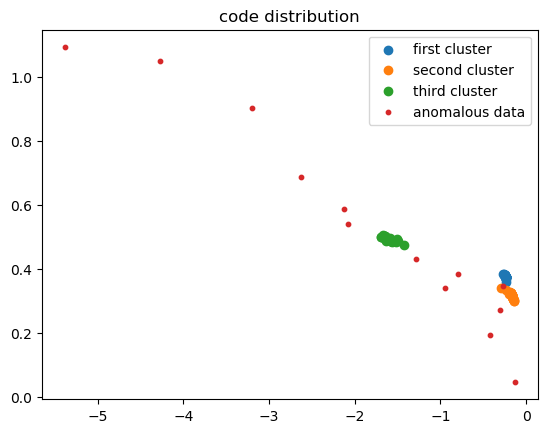

In [14]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()